# LIME: Local Interpretable Model-agnostic Explanations

## Definition and intuition

LIME is a interpretability method that explains a single predictions of any classifier or regressor, by approximating it locally with an interpretable model.

LIME is based on two simple ideas: **perturbation** and local **surrogate model**.  

1. **Perturbation**  
LIME takes a prediction you want to explain and systematically perturbs its inputs. This creates perturbed in a neighborhood inputs become new, labelled training data for a simpler approximate model.

2. **Surrogate model**    
LIME then fits an interpretable model (linear model, decision tree, ...) to describe the relationships between the (perturbed) inputs and outputs.   

Figures below shows the intuition:

![Image of a LIME intuition](ressources/lime_intuition_1.png)

![Image of a LIME intuition - zoom on local model](ressources/lime_intuition_2.png)


For more details on the inner workings of LIME see the <a href='https://arxiv.org/pdf/1602.04938.pdf'>original paper: Why should I trust you?</a> by Ribeiro et al.
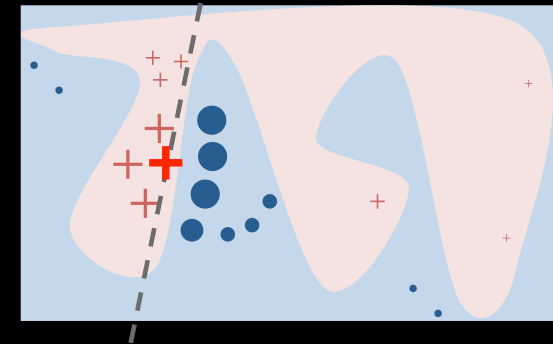

## Interpretability with LIME

### Characteristics 
* Model-agnostic: This method is agnostic to the model we use 
* Local: provides explanations for a singe decision

## Importations
The implementation of LIME used in this notebook is from the implementation of one of the creators ([see on GitHub](https://github.com/marcotcr/lime))

In [1]:
from lime import lime_tabular, lime_text 

# Importing black box models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.utils import check_random_state

# import datasets
from mlinutils.datasets import Bikes, Loans

import mlinutils.sanity as san

In [2]:
#  make plot outputs appear and be stored within the notebook
%matplotlib inline

### Guidance on how to read this notebook

In order to see LIME in action we will use it for different tasks, and we will use two black box models to explain: Random Forests and Multi-Layer Perceptron.

* <a href=#reg>Regression Task: predicting Bike sharing rentals</a>
    * <a href=#regrfm>Bike sharing rentals with Random Forest</a>
        * <a href=#reg_lime>Create LIME Explainer for Bikes Sharing</a>
        * <a href=#reg_lime_local_rf>Explain Random Forest Regressor</a>
    * <a href=#regmlp>Bike sharing rentals with Multi-Layer Perceptron</a>
        * <a href=#regmlpe>Explain MLP Regressor</a>
    * <a href=#reg_compare_models>Can we compare the behavior of the two models using LIME?</a>
* <a href=#clf>Classification Task: predicting Lending Club loans default</a>
    * <a href=#clf_rf>Lending Club prediction with Random Forest</a>
        * <a href=#clf_lime_local_rf>Explain Random Forest Classifier</a>
    * <a href=#clfmlp>Lending Club prediction with Multi-Layer Perceptron</a>
        * <a href=#clfmlpe>Multi-layer Perceptron Explanation </a>
* <a href=#txt>Spam Detection from YouTube comments of the Gangnam style video</a>
    * <a href=#txtrfm>Model creation and sanity checks</a>
    * <a href=#txtrfe>Spam Detection Model Explanation</a>
* <a href=#conc>Conclusion</a>

## The datasets we're using 

### Data description
The full description of the Datasets that are used in this entire collection of notebooks is available separately:
* Bike sharing: Daily counts of bike rentals from bike sharing along with weather and seasonal information. <a href="bike_sharing_dataset.ipynb">See bike sharing dataset exploration</a>.
* Lending club: information on users and wether or not they default on their payments from a peer to peer lending online service <a href="lending_club_dataset">see lending club dataset exploration</a>  

### Data importation 

In [3]:
# Importing bike sharing
bikes = Bikes()
bk_X_train, bk_X_test, bk_y_train, bk_y_test = bikes.load(dummies=False) # LIME needs the raw data (see later)

### Data preview
Take a peak into the data we'll be using !

In [4]:
bikes.preview()

This dataset contains 17379 instances with 14 attributes


,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
4217,fall,0.0,June,11am-4pm,0.0,Wednesday,1.0,Good,33.62,35.605,30.0,11.0014,189.0,179.0
12540,summer,1.0,June,5pm-8pm,0.0,Monday,1.0,Medium,32.80,35.605,41.0,23.9994,800.0,527.0
11540,summer,1.0,May,9pm-5am,0.0,Tuesday,1.0,Medium,20.50,24.240,63.0,8.9981,21.0,486.0
417,spring,0.0,January,6am-10am,0.0,Wednesday,1.0,Medium,10.66,13.635,93.0,8.9981,47.0,18.0
3144,summer,0.0,May,9pm-5am,0.0,Sunday,0.0,Good,22.96,26.515,83.0,0.0000,117.0,134.0


## Regression Task: predicting Bike sharing rentals <a name=reg>

##### Prepare data to LIME

LIME needs a function that takes raw inputs (in order to pertub values correctly) and returns a prediction. Here we use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME. 

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from collections import defaultdict

Track categorical and numercial indices for later usage. Moreover, keep a inverse mapping for categorical columns with their names and values in order to feed LIME explainer later.

In [6]:
bikes_cat_features_idx = [idx for idx, dtype in enumerate(bk_X_train.dtypes) if dtype.kind == 'O']
bikes_cat_features_names = bk_X_train.columns[bikes_cat_features_idx]
bikes_cat_names_indices_map = dict(zip(bikes_cat_features_names, bikes_cat_features_idx))

bikes_num_features_idx = [idx for idx, dtype in enumerate(bk_X_train.dtypes) if dtype.kind in {'i', 'f'}]

Encodes categorical values with a number (required for one-hot encoding) and keeps a mapping with each categorical feature names and their values (needed for LIME)

In [7]:
bikes_cat_name_label_encoder_map = defaultdict(LabelEncoder)

# fit and transform on train set only
bk_X_train[bikes_cat_features_names] = bk_X_train[bikes_cat_features_names].apply(lambda x: bikes_cat_name_label_encoder_map[x.name].fit_transform(x))

bikes_cat_names_values = dict([(bikes_cat_names_indices_map[name], le.classes_) for name, le in bikes_cat_name_label_encoder_map.items()])

Once you have prepared the train set we apply all transformations to the test set

In [8]:
bk_X_test[bikes_cat_features_names] = bk_X_test[bikes_cat_features_names].apply(lambda x: bikes_cat_name_label_encoder_map[x.name].transform(x))

### Bike sharing rentals with Random Forest <a name=regrfm>

Here we create a Random Forest model for predicting the number of rentals per hour. Random Forest is a robust and powerful algorithm widely used by data scientists. It's often considered as a black-box model. We will use LIME to understand a single prediction made by the model.

In [9]:
bikes_categorical_encoding = OneHotEncoder(sparse=False, categorical_features=bikes_cat_features_idx)

bike_rf = RandomForestRegressor(n_estimators=300, max_depth=12, max_features="sqrt", random_state=22) 

bikes_pipeline_rf = make_pipeline(bikes_categorical_encoding, bike_rf)
bikes_pipeline_rf.fit(bk_X_train, bk_y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=[0, 2, 3, 5, 7],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=False)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='s...stimators=300, n_jobs=1,
           oob_score=False, random_state=22, verbose=0, warm_start=False))])

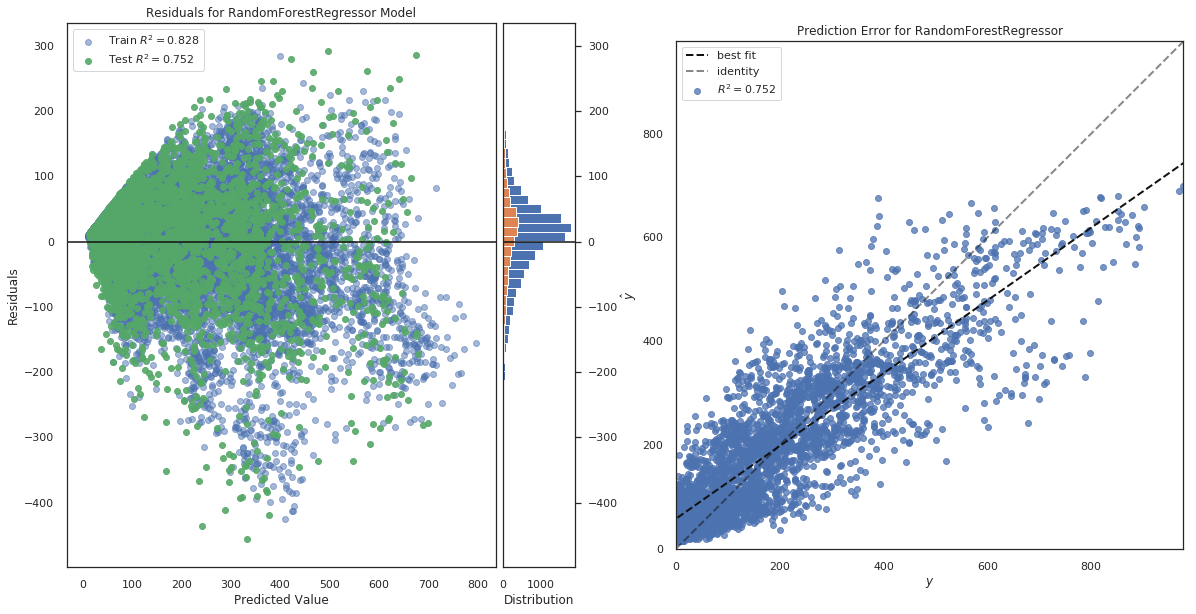

In [10]:
san.regression_sanity_check(bikes_pipeline_rf, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

##### Create LIME Explainer for Bikes Sharing  <a name=reg_lime>

In [11]:
bikes_lime_explainer = lime_tabular.LimeTabularExplainer(training_data=bk_X_train.values, 
                                                         feature_names=bk_X_train.columns, 
                                                         class_names=['count'], 
                                                         categorical_features=bikes_cat_features_idx,
                                                         categorical_names=bikes_cat_names_values,
                                                         verbose=True, 
                                                         mode='regression', 
                                                         random_state=22)

In [12]:
sample_bike = bk_X_test.iloc[55]

## recovers the original format just for reading convenience
bikes.data.iloc[[sample_bike.name],:]

,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
16133,winter,1.0,November,9pm-5am,0.0,Friday,1.0,Good,13.12,16.665,81.0,6.0032,162.0,678.0


Explain Random Forest Regressor <a name=reg_lime_local_rf>

Intercept 249.92973138820804
Prediction_local [78.09797253]
Right: 69.67145479837995


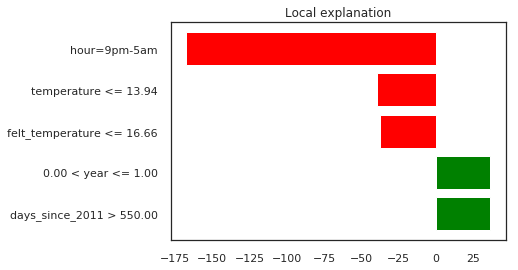

In [13]:
# ensure reproducibility as LIME perturb numerical features by sampling from a Normal(0,1) and categorical features by sampling according to the training distribution
bikes_lime_explainer.random_state = check_random_state(22)

bikes_rf_explainer = bikes_lime_explainer.explain_instance(sample_bike, bikes_pipeline_rf.predict, num_features=5)
bikes_rf_explainer.as_pyplot_figure();

Features contributions can be retrieved via the API as well:

In [14]:
bikes_rf_explainer.as_list()

[('hour=9pm-5am', -167.62121693977093),
 ('temperature <= 13.94', -39.67710003047906),
 ('felt_temperature <= 16.66', -37.25119929786616),
 ('0.00 < year <= 1.00', 36.573194574111334),
 ('days_since_2011 > 550.00', 36.14456284007933)]

> Remarks about explanation:
* LIME discretizes continuous features in order to make the explanation clearer.  
* Here we notice that the explanation for the expected bike count is heavily influenced by the hour of the day since bike sharing is less used at night  
* The fact that the temperature and the felt temperature (two correlated features) are slightly cold seems to discourage users from renting bikes
* The trend throughout the time (`year` and `days_since_2001`) have a positive influence on bike rentals

These explanations are in line prior beliefs about the business of bike sharing rentals (<a href="bike_sharing_dataset.ipynb">see bike sharing dataset exploration</a>.) and features contributions and their importances are compelling.

### Bike sharing rentals with Multi-Layer Perceptron <a name=regmlp>

Let's try another type of machine learning algorithm. We use a Neural Networl model most know as Multi-layer Perceptron (MLP).
It is worth noting that MLP fitting is high sensitive to feature scaling, so we scale numerical data to [0, 1] before feedind data to the algorithm.

In [15]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [16]:
bikes_numerical_pipeline = Pipeline([
    ('numerical_selector', FunctionTransformer(lambda data: data[:,bikes_num_features_idx])),
    ('min_max_scaler', MinMaxScaler()),
    ])

bikes_categorical_pipeline = Pipeline([
    ('categorical_selector', FunctionTransformer(lambda data: data[:,bikes_cat_features_idx])),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

bikes_preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", bikes_numerical_pipeline),
    ("categorical_pipeline", bikes_categorical_pipeline),
    ])

##### Model creation and sanity checks <a name=regmlpm>

In [17]:
bike_mlp = MLPRegressor(hidden_layer_sizes=(25, 75, 100), alpha=10, learning_rate_init=0.01, max_iter=6000, early_stopping=True, random_state=22)

pipeline_mlp = make_pipeline(bikes_preprocessing_pipeline, bike_mlp)
pipeline_mlp.fit(bk_X_train, bk_y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('numerical_pipeline', Pipeline(memory=None,
     steps=[('numerical_selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7fecfc6a89d8>, inv_kw_args=None,
          inverse_func=None, kw_arg...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

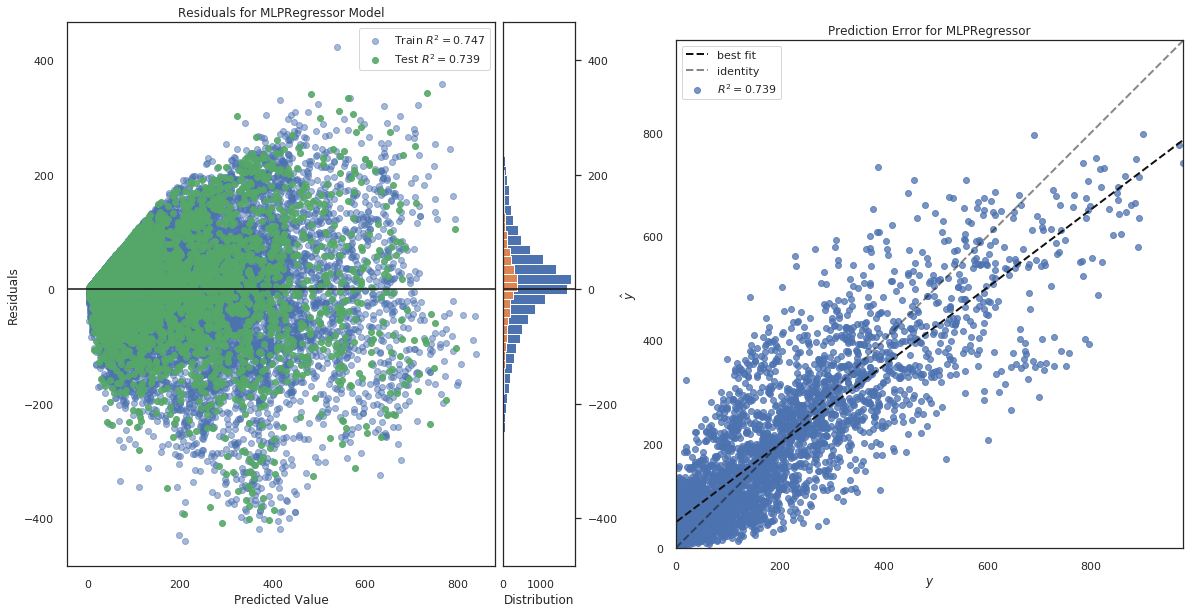

In [18]:
san.regression_sanity_check(pipeline_mlp, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

##### Explain MLP Regressor <a name=regmlpe>

Intercept 208.19822668975684
Prediction_local [76.21909099]
Right: 45.61326084080723


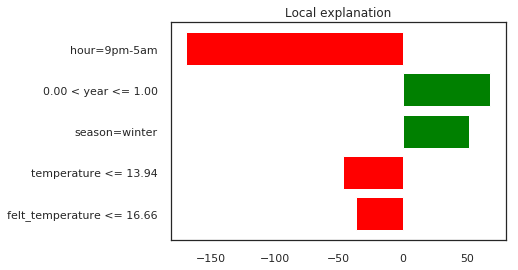

In [19]:
# ensure reproducibility as LIME perturb numerical features by sampling from a Normal(0,1) and categorical features by sampling according to the training distribution
bikes_lime_explainer.random_state = check_random_state(22)

bikes_mlp_explainer = bikes_lime_explainer.explain_instance(sample_bike, pipeline_mlp.predict, num_features=5)
bikes_mlp_explainer.as_pyplot_figure();

> Remarks about the explanation:
* MLP prediction explanation has four features in common with the RandomForest model, they both picked up on the upwards trend `year` and the negative impact of hour of the day, temperature and felt temperature.
* However, MLP models seems to put some positive impact on the feature season when it is winter. It is somewhat contradictory to our expectations. (<a href="bike_sharing_dataset.ipynb">see bike sharing dataset exploration</a>). This can come from several sources: over or under fitting model, a corner case which the average behaviour masked, issues with correlated features (season ≡ month?). In any case, being able to debug a model at a local level is a great tool for data scientist ti improve or understand better their models.   

**Can we compare the behavior of the two models using LIME?** <a name=reg_compare_models>

* In theory, yes, taking a few instances and explaining them for both models can give us a gist of why the models predict different things
* In practice many problems prevent a proper comparison, LIME is not locally accurate, meaning that the value that we find using the explanation model is pretty far from the value found by the real model to draw conclusions
* Moreover setting LIME hyperparameters to different values can give us explanation that are very different and not very coherent. Reproducibility is another real issue with LIME. Explore the notebook [LIME parameters](LIME_parameters.ipynb) to see an example of how different initializations for the explainer and the explanations impact the final explanation.

## Classification Task: predicting Lending Club loans default<a name=clf>

In [20]:
# Importing lending club data set
loans = Loans()
ln_X_train, ln_X_test, ln_y_train, ln_y_test  = loans.load(dummies=False)

### Data preview
Take a peak into the data we'll be using!

In [21]:
loans.preview()

This dataset contains 98339 instances with 19 attributes


,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
26026,10000.0,14.47,344.07,5.0,10.0,MORTGAGE,145000.0,Not Verified,debt_consolidation,17.35,1.0,1.0,8.0,5625.0,93.7,1.0,1.0,225.055956,0
36329,19950.0,17.27,498.71,5.0,7.0,MORTGAGE,45000.0,Verified,home_improvement,15.52,0.0,1.0,8.0,16364.0,45.1,1.0,1.0,126.984127,0
54022,20675.0,15.31,719.85,5.0,10.0,RENT,52800.0,Not Verified,credit_card,14.48,0.0,0.0,7.0,10058.0,91.4,1.0,1.0,237.015134,1
78388,8000.0,14.99,277.29,5.0,10.0,MORTGAGE,75300.0,Not Verified,home_improvement,25.60,0.0,0.0,18.0,40471.0,73.5,1.0,1.0,167.001376,1
94633,20000.0,18.99,518.71,3.0,10.0,OWN,80000.0,Source Verified,other,15.84,0.0,1.0,8.0,9609.0,46.9,1.0,1.0,470.021972,0


##### Prepare data to LIME

LIME needs a function that takes raw inputs (categorical values) and returns a prediction. Here we use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME. 

Track categorical and numercial indices for later usage. Moreover, keep a inverse mapping for categorical columns with their names and values in order to feed LIME explainer later.

In [22]:
loans_cat_features_idx = [idx for idx, dtype in enumerate(ln_X_train.dtypes) if dtype.kind == "O"]
loans_cat_features_names = ln_X_train.columns[loans_cat_features_idx]
loans_cat_names_index_map = dict(zip(loans_cat_features_names, loans_cat_features_idx))

loans_num_features_idx = [idx for idx, dtype in enumerate(ln_X_train.dtypes) if dtype.kind in {'i', 'f'}]

Encodes categorical values with number (required for one-hot encoding) and keeps a mapping with each categorical feature names and their values (needed for LIME)

In [23]:
loans_cat_names_values_map = defaultdict(LabelEncoder)
ln_X_train[loans_cat_features_names] = ln_X_train[loans_cat_features_names].apply(lambda x: loans_cat_names_values_map[x.name].fit_transform(x))

loans_cat_names = dict([(loans_cat_names_index_map[name], le.classes_) for name, le in loans_cat_names_values_map.items()])

Once you have prepared the train set we apply all transformations to the test set

In [24]:
ln_X_test[loans_cat_features_names] = ln_X_test[loans_cat_features_names].apply(lambda x: loans_cat_names_values_map[x.name].transform(x))

### Lending Club prediction with Random Forest <a name=clf_rf>

In [25]:
loans_categorical_encoding = OneHotEncoder(sparse=False, categorical_features=loans_cat_features_idx)

loans_rf = RandomForestClassifier(n_estimators=100, max_depth=12, max_features="sqrt", random_state=22) 

loans_pipeline_rf = make_pipeline(loans_categorical_encoding, loans_rf)
loans_pipeline_rf.fit(ln_X_train, ln_y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=[5, 7, 8], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_f...timators=100, n_jobs=1,
            oob_score=False, random_state=22, verbose=0, warm_start=False))])

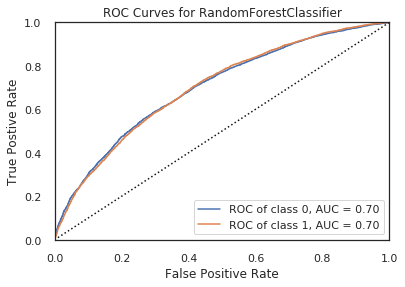

In [26]:
san.classification_sanity_check(loans_pipeline_rf, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

##### Explain Random Forest Classifier<a name=clf_lime_local_rf>

In [27]:
loan_explainer = lime_tabular.LimeTabularExplainer(training_data=ln_X_train.values,
                                                   feature_names=ln_X_train.columns, 
                                                   class_names=['Good_loan_status','Bad_loan_status'], 
                                                   categorical_features=loans_cat_features_idx,
                                                   categorical_names=loans_cat_names,
                                                   verbose=True, 
                                                   random_state=22)

In [28]:
sample_loans = ln_X_test.iloc[3]

## recovers the original format just for reading convenience
loans.data.iloc[[sample_loans.name], :]

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
41230,7000.0,15.61,244.76,4.0,1.0,RENT,56550.0,Source Verified,debt_consolidation,23.6,1.0,1.0,10.0,2193.0,17.8,1.0,1.0,53.980575,1


Intercept 0.22075469022341643
Prediction_local [0.31793375]
Right: 0.2930063277344746


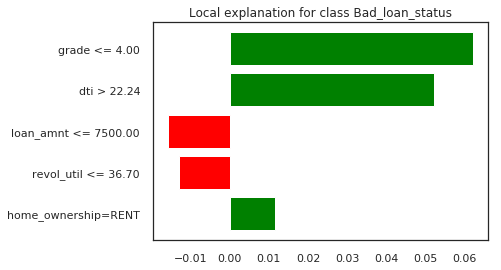

In [29]:
# ensure reproducibility as LIME perturb numerical features by sampling from a Normal(0,1) and categorical features by sampling according to the training distribution
loan_explainer.random_state = check_random_state(22)

loan_rf_explainer = loan_explainer.explain_instance(sample_loans, loans_pipeline_rf.predict_proba, num_features=5)
loan_rf_explainer.as_pyplot_figure();

> Remarks about the explanatio:
* Linear local prediction is close to the complex model
* Lending club grade less than 4 and the ratio calculated using the borrower’s total monthly debt payments on the total debt obligations (`dti`) contribute positively to default. Meaning these are the features that make the model suspect that this loan is a bad one
* Conversely, a not so high applied amount (less than $7500) and a revolving line utilization rate less than 36% (`revol_util`) contributes to a low probability of default.
* With LIME we can plot the explanation for each possible class, here we decided to go with the positive class (Bad loan)
* The explanation is overall coherent with what we've concluded from the lending club data exploration (<a href="lending_club_dataset">see lending club dataset exploration</a> )

#### Lending Club prediction with Multi-Layer Perceptron <a name=clfmlp>
    
Again, Multi-layer Perceptron is sensitive to feature scaling, so we scale numerical data.

In [30]:
loans_numerical_pipeline = Pipeline([
    ('numerical_selector', FunctionTransformer(lambda data: data[:,loans_num_features_idx])),
    ('min_max_scaler', MinMaxScaler()),
    ])

loans_categorical_pipeline = Pipeline([
    ('categorical_selector', FunctionTransformer(lambda data: data[:,loans_cat_features_idx])),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

loans_preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", loans_numerical_pipeline),
    ("categorical_pipeline", loans_categorical_pipeline),
    ])

##### Model creation and sanity checks <a name=clfmlpm>

In [31]:
loans_mlp = MLPClassifier(hidden_layer_sizes=(50), 
                          learning_rate_init=0.05,
                          max_iter=10000, 
                          early_stopping=True, 
                          random_state=22)

loans_pipeline_mlp = make_pipeline(loans_preprocessing_pipeline, loans_mlp)
loans_pipeline_mlp.fit(ln_X_train, ln_y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('numerical_pipeline', Pipeline(memory=None,
     steps=[('numerical_selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7fecfad83f28>, inv_kw_args=None,
          inverse_func=None, kw_arg...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

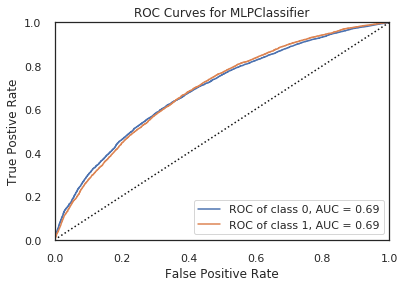

In [32]:
san.classification_sanity_check(loans_pipeline_mlp, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

##### Multi-layer Perceptron Explanation <a name=clfmlpe>

Intercept 0.16948493081793278
Prediction_local [0.32789471]
Right: 0.3483267442389711


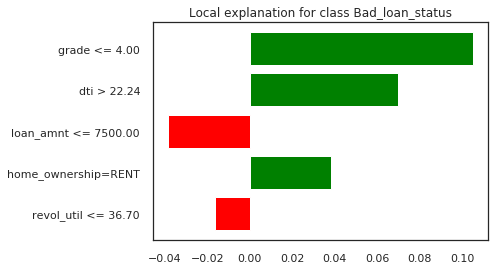

In [33]:
# ensure reproducibility as LIME perturb numerical features by sampling from a Normal(0,1) and categorical features by sampling according to the training distribution
loan_explainer.random_state = check_random_state(22)

loan_mlp_explainer = loan_explainer.explain_instance(sample_loans, loans_pipeline_mlp.predict_proba, num_features=5)
loan_mlp_explainer.as_pyplot_figure();

> Remarks about the explanation:
* grade less than 4 is captured by both model as increasing the default probability
* MLP model seems to put more influence on home ownership status "RENTAL" than the Random Forest model. In the same vein, either `dti` feature contributes positevely it has much less influence for the MLP model than to the Random Firest. This could be due to many things: many features are pretty correlated so the model could choose to rely one feature rather than the other, the fact that the model predict the same class but with very different levels of certainty could also play a role. 
* A new feature `debt_consolition` appears in MLP prediction explanation. 

### Spam Detection from YouTube comments of the Gangnam style video<a name=txt>

Required imports for handling text data set

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lime.lime_text import LimeTextExplainer

import pandas as pd

Load the data set and create train/test data sets

In [35]:
gangnam_comments = pd.read_csv("datasets/comments.csv")

gc_X_train, gc_X_test, gc_y_train, gc_y_test = train_test_split(gangnam_comments['CONTENT'],
                                                                gangnam_comments['CLASS'], 
                                                                test_size=0.5, 
                                                                stratify=gangnam_comments['CLASS'],
                                                                random_state=42)
gc_class_names = ['Legitime', 'Spam']

##### Model creation and sanity checks <a name=txtrfm>

In [36]:
gangnam_comments_rf = RandomForestClassifier(n_estimators=300, max_depth=12, max_features="sqrt", random_state=22) 

gangnam_comments_pipeline = make_pipeline(TfidfVectorizer(lowercase=True), gangnam_comments_rf)
gangnam_comments_pipeline.fit(gc_X_train, gc_y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...timators=300, n_jobs=1,
            oob_score=False, random_state=22, verbose=0, warm_start=False))])

Check basic performance on train and test data set

In [37]:
from sklearn.metrics import f1_score

print("F1 score train set:", f1_score(gc_y_train, gangnam_comments_pipeline.predict(gc_X_train)))
print("F1 score test set:", f1_score(gc_y_test, gangnam_comments_pipeline.predict(gc_X_test)))

F1 score train set: 0.9942857142857142
F1 score test set: 0.9707602339181286


##### Spam Detection Model Explanation <a name=txtrfe>

In [38]:
spam_comment_sample = gc_X_test.iloc[0]

## recovers the original format just for reading convenience
gangnam_comments.iloc[[gc_X_test[0:1].index[0]], :]

,CONTENT,CLASS
311,Please check out my vidios guys﻿,1


In [39]:
gangnam_comments_explainer = LimeTextExplainer(class_names=gc_class_names, verbose=True, random_state=22)

In [40]:
spam_comment_explainer = gangnam_comments_explainer.explain_instance(spam_comment_sample, gangnam_comments_pipeline.predict_proba, num_features=10)

print('Probability(spam) =', spam_comment_explainer.predict_proba[1])
print('True class: %s' % gc_class_names[gc_y_test.iloc[0]])

Intercept 0.41914533733325776
Prediction_local [0.8347071]
Right: 0.8130163285502309
Probability(spam) = 0.8130163285502309
True class: Spam


In [41]:
spam_comment_explainer.show_in_notebook(text=True)

In [42]:
legitime_comment_sample = gc_X_test.iloc[7]

## recovers the original format just for reading convenience
gangnam_comments.iloc[[gc_X_test[7:8].index[0]], :]

,CONTENT,CLASS
150,Oppa! Yeah! Best Song!﻿,0


In [43]:
legitime_comment_explainer = gangnam_comments_explainer.explain_instance(legitime_comment_sample, gangnam_comments_pipeline.predict_proba, num_features=10)

print('Probability(spam) =', legitime_comment_explainer.predict_proba[1])
print('True class: %s' % gc_class_names[gc_y_test.iloc[7]])

Intercept 0.36083970414163874
Prediction_local [0.35257252]
Right: 0.35413375311439566
Probability(spam) = 0.35413375311439566
True class: Legitime


In [44]:
legitime_comment_explainer.show_in_notebook(text=True)

> Remarks on both explanations:
* Text highlighting explanation reveals things that exist in the data, spammers use words like 'my', 'check out'

### Conclusion <a name=conc>

There are a few remarks that Iwe had after studying both the paper and the python library:
* The library evolved from he paper thanks to the active community and it's still evolving 
* The explainer can be very unstable (see the notebook that tests [LIME parameters](LIME_parameters.ipynb))
* Tuning hyperparameters is not always clear 
* Numerical perturbation does not reflect data distribution and leads to contradictory explanations.